# Bayesian Hierarchical Model to create rankings of housings nearby Duke University

## 1. Intro

All graduate students in Duke are responsible for obtaining their off-campus housing. For this reason, several resources are provided to search for available options, and frankly there are too many to consider.  Therefore, I decided to create housing rankings nearby Duke to narrow down my choices.

## 2. Data Extraction & Analysis

From the beginning, I'll limit myself to 23 apartments that have received feedbacks from Duke community (grad/prof students, undergrads, faculty etc.). The 2013 Apartment Copmlex Report published by Duke Community Housing has all the information and feedbacks about each complexes.

So let's start by extracting the data from this report.

In [1]:
# The report is in pdf format
import PyPDF2
pdfFileObj = open('housing_report.pdf','rb')
pdfReader = PyPDF2.PdfFileReader(pdfFileObj)
# no. of pages
num_pages = pdfReader.numPages
print(num_pages)

26


Each page from page 4 to 26 corresponds to a single apartment and contains information such as the number of people recommending this property, evaluation of building condition etc.

For example, page 4 looks like this.

<a href="http://imgur.com/3p9IgH0"><img src="http://i.imgur.com/3p9IgH0.png" title="source: imgur.com" /></a>

First, we consider a simple approch which is to just rank each property by the proportion of people recommended.

So we only need to extract the name of the property and the number of people who answered yes and no to the question "Recommended?".

Let's conduct this operation to all 23 pages (p.4-26) and take look at the resulting data frame.

In [2]:
import re
import pandas as pd

names = []
yes_counts =[]
no_counts = []
yes_regex = re.compile(r'Yes[^:]*:\s*(\d+)')
no_regex = re.compile(r'No[^:]*:\s*(\d+)')

for idx in range(3,num_pages):
    pageObj = pdfReader.getPage(idx)
    txt = pageObj.extractText()
    name = txt.splitlines()[3].strip()
    names.append(name)
    yes = int(yes_regex.findall(txt)[0])
    yes_counts.append(yes)
    no = int(no_regex.findall(txt)[0])
    no_counts.append(no)

# p.19 and 26 for some reason have way too much newlines so that it couldn't be captured
names[15] = 'Poplar West'
names[22] = 'Yorktown Club'

names = pd.Series(names,name = 'names')
yes_counts = pd.Series(yes_counts,name = 'yes_counts')
no_counts = pd.Series(no_counts,name ='no_counts')

housing = pd.concat([names,yes_counts,no_counts],axis = 1)
housing

,names,yes_counts,no_counts
0,Alden Place Apartments,15,3
1,"Belmont, The Belmont At Duke",28,7
2,Campus Walk Apartments,14,1
3,Century Trinity Estates,4,2
4,Erwin Terrace,6,0
5,Evergreens at Mt. Moriah,4,1
6,"Forest, The Forest Apartments",6,2
7,Garrett West Apartments,12,0
8,Georgetown,5,0
9,The Heights at LaSalle,25,4


Then we construct a new column called "yes_ratio" to represent the proportion of people recommended and rank each housing by its value. 

I'll only consider those above 10th place to be worth looking for.

In [3]:
yes_ratio = housing.yes_counts/(housing.no_counts+housing.yes_counts)
yes_ratio.name = 'yes_ratio'

housing = pd.concat([housing,yes_ratio],axis = 1)
ranking = housing.sort_values(by =["yes_ratio"],ascending = False).iloc[:10,:]
ranking

,names,yes_counts,no_counts,yes_ratio
11,Lenox at Patterson Place,10,0,1.000000
7,Garrett West Apartments,12,0,1.000000
14,Pinnacle Ridge,10,0,1.000000
13,Parc at University Tower,16,0,1.000000
8,Georgetown,5,0,1.000000
22,Yorktown Club,5,0,1.000000
4,Erwin Terrace,6,0,1.000000
18,Trinity Commons,21,1,0.954545
2,Campus Walk Apartments,14,1,0.933333
16,Residences at Erwin Mill,13,1,0.928571


We can immediately spot the problem of this approach. 

How can be sure that a property unanimously recommended by 5 people (e.g. Georgetown) to be superior to the one recommended by 21 out of 22 people (e.g. Trinity Commons)?

The issue here is that some properties have much less feedbacks compared to the other and therefore the uncertainty of the estimate is grater for those, thus difficult to compare.

However, if we can obtain a posterior distribution of each estimate, we would be able to rank those accordingly. This seems like a Bayesian problem.

## 3. Constructing a Hierarchical Model

Bayesian Hierarchical Model is a typical Bayesian solution to this kind of dataset with varing degree of uncertainty in individual estimates.

It incorporates pooled estimate to the individual estimate to create a distribution of the combined estimate.

For the remainder of this notebook, $\theta$ denotes the vector of parameters we want to estimate (= true proportion of positive recommendations) and $y$ the vector of observed number of people recommending each properties and $n$ the vector of total number of people giving the feedback (so those who answered yes + no).

### 3.1 Assumptions

The assumption of this model is that $\theta$s corresponding to $y$s are exchangable which means that any of $\theta_j$'s are distinguishable from any others, so no ordering or grouping of the parameters can be made and thus we must assume symmetry among the parameters. The figure below illustrates this notion visually.

<a href="http://imgur.com/43cZ4Y4"><img src="http://i.imgur.com/43cZ4Y4.png" title="source: imgur.com" /></a>

Given this symmetry, we can consider $\theta$'s to be an iid sample from an distribution with some unknown parameters.

The resulting hierarchical model looks like following:

<a href="http://imgur.com/AnLMjjj"><img src="http://i.imgur.com/AnLMjjj.png" title="source: imgur.com" /></a>

### 3.2 Constructing a Hierarchical Model

Note: This part borrows heavily from [pymc3 documentations](https://pymc-devs.github.io/pymc3/notebooks/hierarchical_partial_pooling.html) and I have a difficulty in understanding some parts although I'll try to explain as much as I know.

In constructing a hierarchical model, we need prior distributions not just to the target parameter $\theta$ but also to hyperparameters $\alpha,\beta$ (in this setting, it could be anything like $\mu,\sigma^2$ etc.). 

Because $\theta$'s are probability on the interval $[0,1]$ we assume 

\begin{align}
\theta_j \sim Beta(\alpha,\beta)
\end{align}

Then $y$ is drawn from a binomial sampling distribution  with the following form

\begin{align}
y_j \sim Binom(n_j,\theta_j)
\end{align}

The observed positive recommendation ratio is just $y_j/n_j$.

Finally, we arrived to the most trickiest part: the construction of hyperpriors (priors of $\alpha,\beta$).

For mathematical convenience, rather than directly constructing priors for $\alpha$ and $\beta$ we transform those to mean $\phi = \alpha/(\alpha+\beta)$ and scale $\kappa = \alpha+\beta$.

Given these, we can derive back $\alpha,\beta$ by 

\begin{align}
\alpha &= (\alpha+\beta)\Big(\frac{\alpha}{\alpha+\beta}\Big)\\
\beta &=　(\alpha+\beta)\Big(1-\frac{\alpha}{\alpha+\beta}\Big)
\end{align}

The mean is in $[0,1]$, thus we can use a uniform or beta prior to account for uninformativeness.

\begin{align}
\phi = \frac{\alpha}{\alpha+\beta} \sim Uniform(0,1) = Beta(1,1)
\end{align}

However, the scale parameter could take any value between 0 to $\infty$ and assigning a unifrom distribution will cause the integration to  diverge. Thus a Pareto prior

\begin{align}
\kappa= \alpha+\beta &\sim Pareto(1.5,1) \mbox{ where }\\
Pareto(x|\gamma,k) &\sim x^{-\gamma+1} \mbox{ defined on $[k,\infty)$}
\end{align}

is used instead. This will  favor smaller values as seen below.

In [4]:
import matplotlib.pyplot as plt
import numpy as np
x  = np.arange(1,100,0.1)

def pareto(val,gamma):
    ret =[]
    for idx in val:
        ret.append(idx**(-gamma+1))
    return ret

plt.xlim(np.min(x),np.max(x))
plt.plot(x,pareto(x,1.5))

 ### 3.3 MCMC to generate the posterior distribution
 
 Now we have all ingredients to get a posterior distribution of $\theta$ with MCMC.

Auto-assigning NUTS sampler...
Initializing NUTS using ADVI...
Average Loss = 45.887:   6%|▋         | 12875/200000 [00:02<00:29, 6352.74it/s]
Convergence archived at 12900
Interrupted at 12,900 [6%]: Average Loss = 75.308
100%|██████████| 5500/5500 [00:48<00:00, 113.21it/s]


array([[<matplotlib.axes._subplots.AxesSubplot object at 0x115e9bb70>,
        <matplotlib.axes._subplots.AxesSubplot object at 0x1164214e0>]], dtype=object)

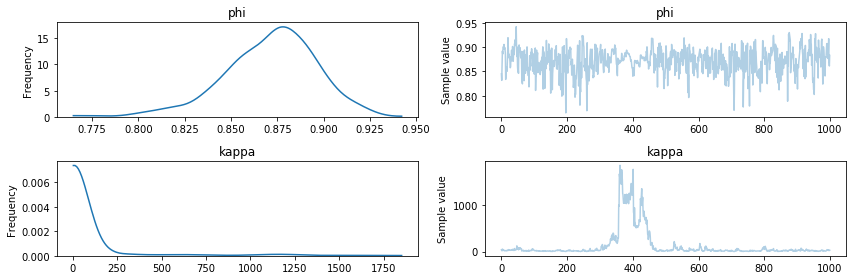

In [5]:
%matplotlib inline
import pymc3 as pm
import numpy as np
import matplotlib.pyplot as plt

total_counts = housing.yes_counts+housing.no_counts
yes_counts = housing.yes_counts

N = housing.shape[0]

BoundedKappa = pm.Bound(pm.Pareto,lower = 1.0)
with pm.Model() as model:
    phi = pm.Uniform('phi', lower = 0.0, upper=1.0)
    kappa = BoundedKappa('kappa', alpha=1.0001, m = 1.5)
    thetas = pm.Beta('thetas',alpha = phi*kappa, beta= (1.0-phi)*kappa, shape=N)
    ys = pm.Binomial('ys', n=total_counts ,p=thetas, observed = yes_counts)

with model:
        trace = pm.sample(5000, nuts_kwargs={'target_accept':.99})
        
pm.traceplot(trace[-1000:],varnames = ['phi','kappa'])

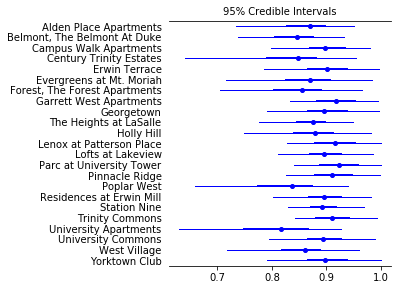

In [6]:
pm.forestplot(trace[-1000:],varnames = ['thetas'],ylabels = housing.names)

(0, 1)

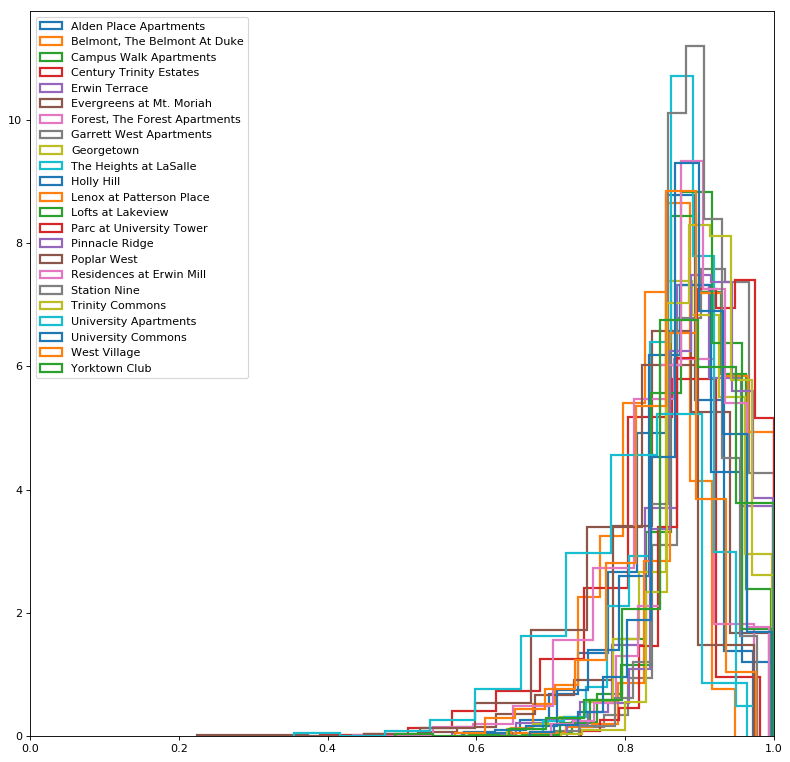

In [7]:
fig=plt.figure(figsize=(12, 12), dpi= 80, facecolor='w', edgecolor='k')
for idx in range(N):
    plt.hist(trace[-1000:]['thetas'][:,idx],normed =True,histtype="step",lw = 2,
             label = housing.names[idx])
plt.legend(loc = "upper left")
plt.xlim(0,1)

In [8]:
lower_bound =[]
for idx in range(N):
    v = np.sort(trace[-1000:]['thetas'][:,idx])[int(0.05*1000)]
    lower_bound.append(v)
lower_bound = pd.Series(lower_bound,name = "lower_bound")
housing = pd.concat([housing,lower_bound],axis=1)

In [9]:
ranking_2 = housing.sort_values(by =["lower_bound"],ascending = False).iloc[:10,:]
ranking_2

,names,yes_counts,no_counts,yes_ratio,lower_bound
18,Trinity Commons,21,1,0.954545,0.843827
13,Parc at University Tower,16,0,1.000000,0.839932
7,Garrett West Apartments,12,0,1.000000,0.835522
17,Station Nine,38,4,0.904762,0.833696
11,Lenox at Patterson Place,10,0,1.000000,0.828005
14,Pinnacle Ridge,10,0,1.000000,0.827293
12,Lofts at Lakeview,21,2,0.913043,0.813844
2,Campus Walk Apartments,14,1,0.933333,0.807830
16,Residences at Erwin Mill,13,1,0.928571,0.806307
20,University Commons,12,1,0.923077,0.800419


In [10]:
ranking

,names,yes_counts,no_counts,yes_ratio
11,Lenox at Patterson Place,10,0,1.000000
7,Garrett West Apartments,12,0,1.000000
14,Pinnacle Ridge,10,0,1.000000
13,Parc at University Tower,16,0,1.000000
8,Georgetown,5,0,1.000000
22,Yorktown Club,5,0,1.000000
4,Erwin Terrace,6,0,1.000000
18,Trinity Commons,21,1,0.954545
2,Campus Walk Apartments,14,1,0.933333
16,Residences at Erwin Mill,13,1,0.928571


### 3.4 Model Checking

To validate our model we conduct posterior predictive checks (PPCs). This is a simple method in which we compare the posterior predictive distribution to the actual outcome. If the outcome is on the far end of the distribution, it is unlikely that the approximation of the underlying true distribution of the target parameter is done right.

In this example, we simulate draws from $y_i$ and compare the distribution of those with the observed value.

In [11]:
ppc = pm.sample_ppc(trace,model = model)

100%|██████████| 5000/5000 [00:01<00:00, 2628.40it/s]


In [12]:
ppc['ys'].shape

(5000, 23)

The histogram of all 23 predictive distributions and the observed values are shown below.

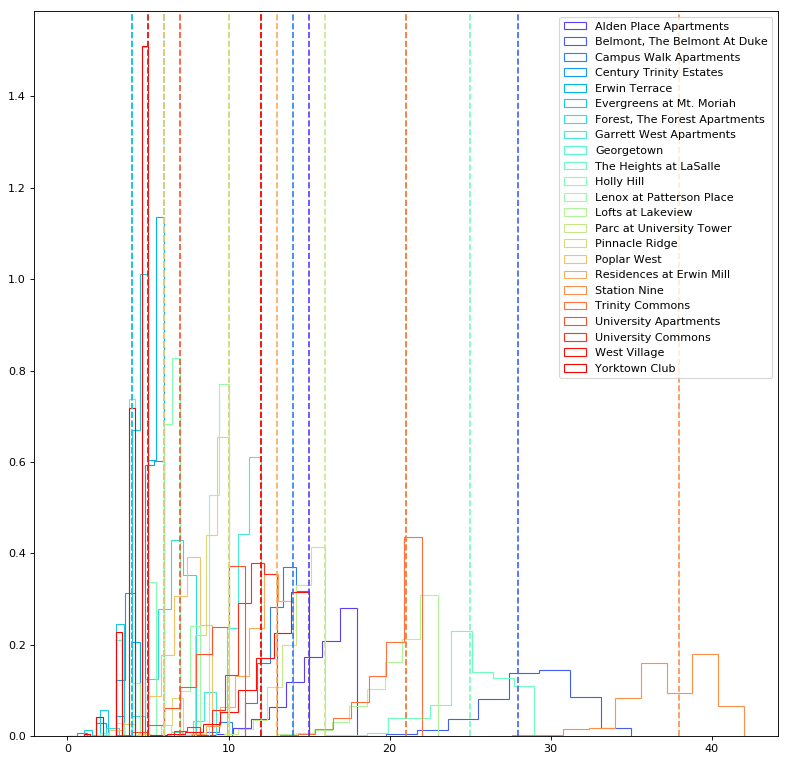

In [13]:
import matplotlib.cm as cm
cmap = cm.get_cmap(name='rainbow')

fig=plt.figure(figsize=(12, 12), dpi= 80, facecolor='w', edgecolor='k')
for idx in range(N):
    plt.hist(ppc['ys'][:,idx],normed =True,histtype="step",lw = 1,
             label = housing.names[idx],color = cmap(20+11*idx))
    plt.axvline(x = housing.yes_counts[idx],linestyle='dashed',color = cmap(20+11*idx))
plt.legend(loc = "upper right")
#plt.xlim(0,1)

For distributions with smaller counts, the figure above is difficult to check so alternativly we can compare the mean of the distribution to the observed value as following

In [14]:
for idx in range(23):
    print([housing.names[idx],float(np.round(ppc['ys'][:,idx].mean(),1)),housing.yes_counts[idx]])

['Alden Place Apartments', 15.4, 15]
['Belmont, The Belmont At Duke', 29.0, 28]
['Campus Walk Apartments', 13.4, 14]
['Century Trinity Estates', 5.0, 4]
['Erwin Terrace', 5.4, 6]
['Evergreens at Mt. Moriah', 4.3, 4]
['Forest, The Forest Apartments', 6.7, 6]
['Garrett West Apartments', 11.0, 12]
['Georgetown', 4.5, 5]
['The Heights at LaSalle', 25.2, 25]
['Holly Hill', 6.1, 6]
['Lenox at Patterson Place', 9.1, 10]
['Lofts at Lakeview', 20.5, 21]
['Parc at University Tower', 14.8, 16]
['Pinnacle Ridge', 9.1, 10]
['Poplar West', 7.3, 6]
['Residences at Erwin Mill', 12.5, 13]
['Station Nine', 37.5, 38]
['Trinity Commons', 20.1, 21]
['University Apartments', 8.7, 7]
['University Commons', 11.6, 12]
['West Village', 12.7, 12]
['Yorktown Club', 4.5, 5]


## 4. Notes and further considerations

This time, I've constructed a simple hierarchical model using only the data of the estimand ($y_i$'s) and no other features such as the buiding condition, price, the distance from the university etc. Hierarchical linear models can incorporate these information to construct even more accurate posterior distribution but my knowledge on this method is insufficient at this time so I decided not to do.

Finally, to make this rankings useful to me, I'll include the rent price to rule out expensive ones from the list.

In [15]:
rent_regex = re.compile(r'1\s?BR[\w\W]*\$([\w\W]*)2\s?BR')
rent_mean =[]
for idx in range(3,num_pages):
    pageObj = pdfReader.getPage(idx)
    txt = pageObj.extractText()
    try:
        rent= np.mean(np.array(rent_regex.findall(txt)[0].replace(",","").replace("\n"," ").replace("-"," ").split(),dtype = int))
    except IndexError:
        rent = float('nan')
    rent_mean.append(rent)
rent_mean[5] = np.mean([849,892])

In [16]:
rent_mean = pd.Series(rent_mean,name = 'rent_mean')
housing = pd.concat([housing,rent_mean],axis = 1)
ranking_2 = housing.sort_values(by =["lower_bound"],ascending = False).iloc[:10,:]
ranking_2

,names,yes_counts,no_counts,yes_ratio,lower_bound,rent_mean
18,Trinity Commons,21,1,0.954545,0.843827,1975.5
13,Parc at University Tower,16,0,1.000000,0.839932,1064.5
7,Garrett West Apartments,12,0,1.000000,0.835522,1061.5
17,Station Nine,38,4,0.904762,0.833696,1325.0
11,Lenox at Patterson Place,10,0,1.000000,0.828005,882.5
14,Pinnacle Ridge,10,0,1.000000,0.827293,1000.0
12,Lofts at Lakeview,21,2,0.913043,0.813844,1312.5
2,Campus Walk Apartments,14,1,0.933333,0.807830,NaN
16,Residences at Erwin Mill,13,1,0.928571,0.806307,712.5
20,University Commons,12,1,0.923077,0.800419,677.5
